In [1]:
import pandas as pd
import re
import numpy as np
import yaml  # To read YAML configuration files
from pathlib import Path  # For cross-platform file path handling


# Load directory paths from configuration file
with open('paths.yml', 'r') as file:
    paths = yaml.safe_load(file)  # Read and parse YAML file

# Create Path objects for each directory
raw = Path(paths['data']['raw'])  # Directory with raw data
temp = Path(paths['data']['temp'])  # Directory with temporary processed data
processed = Path(paths['data']['processed'])  # Directory with final processed data

In [22]:
def expandir_a_trimestres(df_mun):
    """
    Expande un dataframe de un municipio de frecuencia anual a trimestral.
    Los valores anuales se ubican en el Q4 (primer día de octubre).
    """
    rows = []
    
    for _, row in df_mun.iterrows():
        year = int(row['year'])
        mun_code = int(row['mun_code'])
        
        # Crear los 4 trimestres del año
        for q in range(1, 5):
            # Primer mes de cada trimestre: Q1=Enero, Q2=Abril, Q3=Julio, Q4=Octubre
            month = (q - 1) * 3 + 1
            fecha = pd.Timestamp(year=year, month=month, day=1)
            
            if q == 4:
                # Q4 tiene el valor anual
                rows.append({
                    'mun_code': mun_code,
                    'fecha': fecha,
                    'trimestre': q,
                    'year': year,
                    'men': row['men'],
                    'women': row['women'],
                    'total': row['total']
                })
            else:
                # Q1, Q2, Q3 tienen NaN inicialmente
                rows.append({
                    'mun_code': mun_code,
                    'fecha': fecha,
                    'trimestre': q,
                    'year': year,
                    'men': np.nan,
                    'women': np.nan,
                    'total': np.nan
                })
    
    return pd.DataFrame(rows)

In [50]:
def interpolar_iterativo(valores_serie):
    """
    Interpola valores NaN usando el promedio de los valores adyacentes conocidos.
    Primero llena Q2 (entre dos Q4), luego Q1 y Q3.
    Los valores decimales se redondean hacia abajo (floor).
    """
    valores = valores_serie.copy().astype(float)
    n = len(valores)
    
    # Repetir hasta que no haya cambios o se alcance el máximo de iteraciones
    max_iteraciones = 20
    
    for iteracion in range(max_iteraciones):
        cambios = False
        
        for i in range(n):
            if pd.isna(valores[i]):
                # Buscar el valor conocido más cercano hacia atrás
                valor_anterior = None
                for j in range(i - 1, -1, -1):
                    if not pd.isna(valores[j]):
                        valor_anterior = valores[j]
                        break
                
                # Buscar el valor conocido más cercano hacia adelante
                valor_siguiente = None
                for j in range(i + 1, n):
                    if not pd.isna(valores[j]):
                        valor_siguiente = valores[j]
                        break
                
                # Si tenemos ambos valores, calcular el promedio
                if valor_anterior is not None and valor_siguiente is not None:
                    promedio = (valor_anterior + valor_siguiente) / 2
                    valores[i] = np.floor(promedio)  # Redondear hacia abajo
                    cambios = True
        
        if not cambios:
            break
    
    return valores

In [52]:
def procesar_municipio(df_mun):
    """
    Procesa un municipio aplicando la interpolación iterativa.
    """
    df_mun = df_mun.copy().sort_values('fecha').reset_index(drop=True)
    
    # Interpolar cada columna
    df_mun['men'] = interpolar_iterativo(df_mun['men'])
    df_mun['women'] = interpolar_iterativo(df_mun['women'])
    df_mun['total'] = interpolar_iterativo(df_mun['total'])
    
    return df_mun

In [ ]:
df_dane_95_04 = (
    pd.read_excel(raw/'dane'/'demografía'/'DCD-area-sexo-edad-proypoblacion-Mun-1995-2004.xlsx', header=11)
    .query("`ÁREA GEOGRÁFICA` == 'Total'")
    [['DPMP','AÑO','Total Hombres','Total Mujeres','Total General']]
    .rename(columns={'DPMP':'mun_code','AÑO':'year','Total Hombres':'men','Total Mujeres':'women','Total General':'total'})
)

df_dane_05_17 = (
    pd.read_excel(raw/'dane'/'demografía'/'DCD-area-sexo-edad-proypoblacion-Mun-2005-2017_VP.xlsx', header=11)
    .query("`ÁREA GEOGRÁFICA` == 'Total'")
    [['MPIO','AÑO','Total Hombres','Total Mujeres','Total General']]
    .rename(columns={'MPIO':'mun_code','AÑO':'year','Total Hombres':'men','Total Mujeres':'women','Total General':'total'})
)

df_dane_18_25 = (
    pd.read_excel(raw/'dane'/'demografía'/'PPED-AreaSexoEdadMun-2018-2042_VP.xlsx', header=8, sheet_name="PobMunicipalxÁreaSexoEdad")
    .query("`Unnamed: 5` == 'Total' and `Unnamed: 4` <= 2025")    
    [['Unnamed: 2','Unnamed: 4','Hombres','Mujeres','Total']]
    .rename(columns={'Unnamed: 2':'mun_code','Unnamed: 4':'year','Hombres':'men','Mujeres':'women','Total':'total'})
)

df_dane = pd.concat([df_dane_95_04, df_dane_05_17, df_dane_18_25], ignore_index=True).reset_index(drop=True)
df_dane['mun_code'] = df_dane['mun_code'].astype(float).astype(int).astype(str).str.zfill(5)

In [53]:
# Expandir cada municipio a trimestres
df_trimestral = pd.concat([
    expandir_a_trimestres(df_dane[df_dane['mun_code'] == mun]) 
    for mun in df_dane['mun_code'].unique()
], ignore_index=True)

# Ordenar por municipio y fecha
df_trimestral = df_trimestral.sort_values(['mun_code', 'fecha']).reset_index(drop=True)

# Aplicar a todos los municipios
df_final = pd.concat([
    procesar_municipio(df_trimestral[df_trimestral['mun_code'] == mun])
    for mun in df_trimestral['mun_code'].unique()
], ignore_index=True)

print("Dataframe con interpolación completada:")
df_final['total'] = df_final['men'] + df_final['women']
df_final

Dataframe con interpolación completada:


,mun_code,fecha,trimestre,year,men,women,total
0,5001,1995-01-01,1,1995,NaN,NaN,NaN
1,5001,1995-04-01,2,1995,NaN,NaN,NaN
2,5001,1995-07-01,3,1995,NaN,NaN,NaN
3,5001,1995-10-01,4,1995,815013.0,941748.0,1756761.0
4,5001,1996-01-01,1,1996,821789.0,950506.0,1772295.0
...,...,...,...,...,...,...,...
139155,99773,2024-10-01,4,2024,55714.0,48671.0,104385.0
139156,99773,2025-01-01,1,2025,57065.0,49904.0,106969.0
139157,99773,2025-04-01,2,2025,57741.0,50521.0,108262.0
139158,99773,2025-07-01,3,2025,58079.0,50829.0,108908.0


In [ ]:
df_final['mun_code'] = df_final['mun_code'].astype(float).astype(int).astype(str).str.zfill(5)

In [55]:
# Agregar a frecuencia mensual (primer día del mes)
df_final['fecha'] = df_final['fecha'].dt.to_period('M').dt.to_timestamp().dt.date

In [58]:
df_dane_final = (
    df_final
    .dropna()
    .reset_index(drop=True)
    .drop(columns=['trimestre', 'year'])
    .rename(columns={'total':'population', 'fecha':'quarter'})
)

df_dane_final

,mun_code,quarter,men,women,population
0,05001,1995-10-01,815013.0,941748.0,1756761.0
1,05001,1996-01-01,821789.0,950506.0,1772295.0
2,05001,1996-04-01,825177.0,954885.0,1780062.0
3,05001,1996-07-01,826871.0,957075.0,1783946.0
4,05001,1996-10-01,828566.0,959265.0,1787831.0
...,...,...,...,...,...
135786,99773,2024-10-01,55714.0,48671.0,104385.0
135787,99773,2025-01-01,57065.0,49904.0,106969.0
135788,99773,2025-04-01,57741.0,50521.0,108262.0
135789,99773,2025-07-01,58079.0,50829.0,108908.0


In [61]:
df_dane_final['women_share'] = round(df_dane_final['women'] / df_dane_final['population'], 5)
df_dane_final.drop(columns=['men', 'women'], inplace=True)
df_dane_final

,mun_code,quarter,population,women_share
0,05001,1995-10-01,1756761.0,0.53607
1,05001,1996-01-01,1772295.0,0.53631
2,05001,1996-04-01,1780062.0,0.53643
3,05001,1996-07-01,1783946.0,0.53649
4,05001,1996-10-01,1787831.0,0.53655
...,...,...,...,...
135786,99773,2024-10-01,104385.0,0.46626
135787,99773,2025-01-01,106969.0,0.46653
135788,99773,2025-04-01,108262.0,0.46665
135789,99773,2025-07-01,108908.0,0.46672


In [ ]:
df_dane_final.to_parquet(temp /"dane"/"demografía"/"dane_demografia.parquet", index=False)

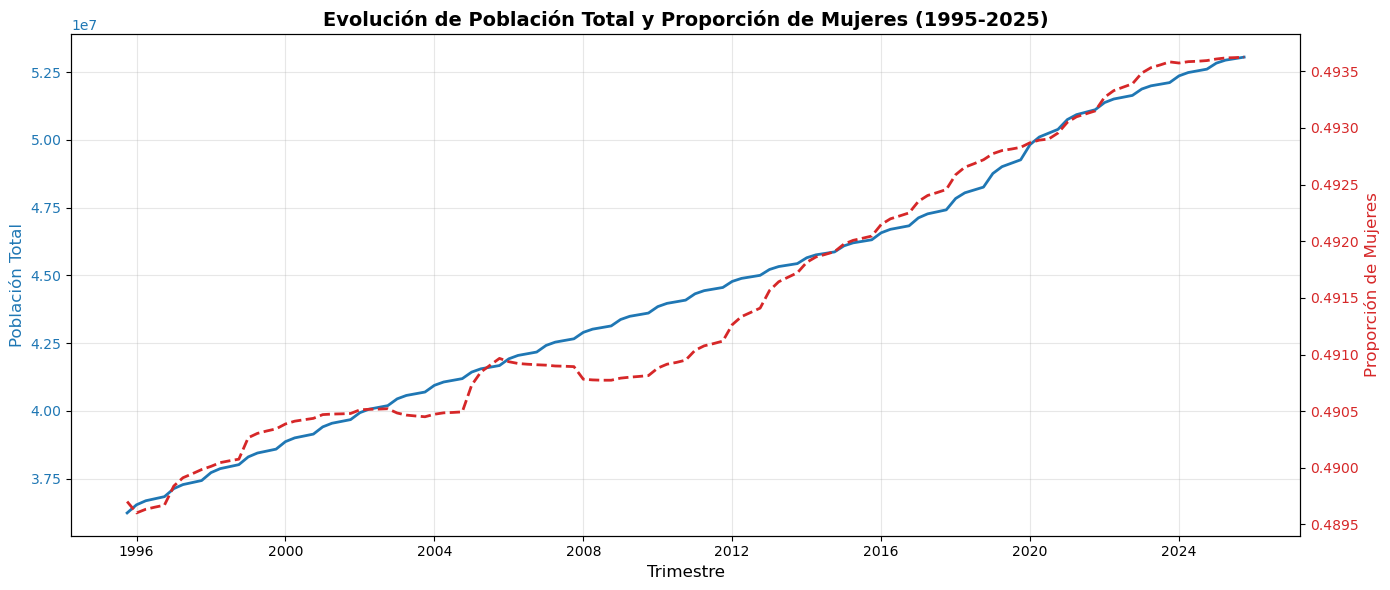

In [62]:
import matplotlib.pyplot as plt

# Asegurar que quarter es datetime
df_dane_final['quarter'] = pd.to_datetime(df_dane_final['quarter'])

# Agrupar por fecha para obtener totales/promedios
df_plot = df_dane_final.groupby('quarter').agg({
    'population': 'sum',  # Población total
    'women_share': 'mean'  # Proporción promedio
}).reset_index()

# Crear figura con dos ejes Y
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje Y izquierdo - Población
color = 'tab:blue'
ax1.set_xlabel('Trimestre', fontsize=12)
ax1.set_ylabel('Población Total', color=color, fontsize=12)
ax1.plot(df_plot['quarter'], df_plot['population'], color=color, linewidth=2, label='Población')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Eje Y derecho - Women Share
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Proporción de Mujeres', color=color, fontsize=12)
ax2.plot(df_plot['quarter'], df_plot['women_share'], color=color, linewidth=2, label='Proporción Mujeres', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Título y layout
plt.title('Evolución de Población Total y Proporción de Mujeres (1995-2025)', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

Para el cálculo de tasas trimestrales por cada 100,000 habitantes, se requirió desagregar las proyecciones poblacionales anuales del Departamento Administrativo Nacional de Estadística (DANE) a nivel trimestral. Dado que las proyecciones oficiales se publican con periodicidad anual, se implementó un procedimiento de interpolación para obtener estimaciones trimestrales.

El valor poblacional anual se asignó al cuarto trimestre de cada año, correspondiente al primer día de octubre. Los trimestres intermedios se estimaron mediante interpolación lineal iterativa, calculando el valor de cada período como el promedio aritmético de los dos valores conocidos más cercanos. Los valores resultantes se redondearon al entero inferior para mantener la coherencia con la naturaleza discreta de los datos poblacionales.

Este procedimiento asume un crecimiento poblacional uniforme entre los puntos de referencia anuales. En consecuencia, no incorpora posibles patrones estacionales asociados a fluctuaciones en natalidad, mortalidad o flujos migratorios. No obstante, para el cálculo de tasas de eventos discretos como indicadores de violencia o variables socioeconómicas, esta aproximación es metodológicamente aceptable por dos razones. Primero, la variación poblacional intra-anual es marginal comparada con la variabilidad observada en los eventos del numerador. Segundo, este enfoque es consistente con las prácticas estándar de organismos como el Instituto Nacional de Salud, el Instituto Nacional de Medicina Legal y Ciencias Forenses, y la Oficina de las Naciones Unidas contra la Droga y el Delito para el cálculo de tasas poblacionales con datos intercensales.